# Data sampling and Image size reshaping

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import pandas as pd
from keras.callbacks import Callback

2024-12-27 16:30:20.927299: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 16:30:21.062103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735313421.132202     418 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735313421.170469     418 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 16:30:21.322593: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Reading statistics

In [2]:
# stats = pd.read_csv("/kaggle/input/image-dimensions/image_dimensions.csv")
stats = pd.read_csv("image_dimensions.csv")
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2797.000000,2797.000000
mean,603.319271,648.314623
std,415.975788,446.883172
min,106.000000,108.000000
25%,314.000000,383.000000
50%,550.000000,590.000000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,550.000000,590.000000


## Helper functions

In [3]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [4]:
def build_model(width, height):
    model = keras.Sequential([
        layers.InputLayer(shape=(width, height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ])
    return model

model = build_model(median_width, median_height)
model.summary()


I0000 00:00:1735313441.455959     418 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 550, 590, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 548, 588, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 274, 294, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 272, 292, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 136, 146, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 134, 144, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 67, 72, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 65, 70, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 35, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 33, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 253440)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       253,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,231,937 (4.70 MB)

 Trainable params: 1,231,937 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def plot_info(axes, type, ylabel):
    axes.set_title(type)
    axes.set_xlabel("Epochs")
    axes.set_ylabel(ylabel)
    axes.legend()
    axes.grid()

def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs_range = range(1, len(history.history["loss"]) + 1)

    _, axes = plt.subplots(4,1, figsize=(12,18))
    axes[0].plot(epochs_range, loss, label="Training loss")
    axes[0].plot(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[0], "Lineair", "Loss")
    

    axes[1].semilogy(epochs_range, loss, label="Training loss")
    axes[1].semilogy(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[1], "Logarithmic", "Loss")

    axes[2].plot(epochs_range, acc, label="Training accuracy")
    axes[2].plot(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[2], "Lineair", "Loss")

    axes[3].semilogy(epochs_range, acc, label="Training accuracy")
    axes[3].semilogy(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[3], "Logarithmic", "Loss")

In [5]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

In [6]:
def print_metrics(model, test):
    y_pred_prob = model.predict(test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    y_true = np.concatenate([y.numpy() for _, y in test], axis=0)

    auc_score = roc_auc_score(y_true, y_pred_prob)

    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("F1: ", f1_score(y_true, y_pred))
    print("ROC AUC: ", roc_auc_score(y_true, y_pred))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1'], 
        ax=ax[0]
    )
    ax[0].set_title('Confusion Matrix')
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    ax[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC)')
    ax[1].legend(loc='lower right')
    ax[1].grid()

In [7]:
class DynamicMetricsDisplayCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get("loss")
        val_loss = logs.get("val_loss")
        accuracy = logs.get("accuracy")
        val_accuracy = logs.get("val_accuracy")
        print(f"Epoch {epoch + 1:02d}: loss = {loss:.4f}, val_loss = {val_loss:.4f}, "
              f"accuracy = {accuracy:.4f}, val_accuracy = {val_accuracy:.4f}")

In [22]:
class DynamicMetricsPlotCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epochs = []
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

        # Set up the plot
        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 5))
        self.ax[0].set_title("Loss")
        self.ax[0].set_xlabel("Epoch")
        self.ax[0].set_ylabel("Loss")
        self.ax[1].set_title("Accuracy")
        self.ax[1].set_xlabel("Epoch")
        self.ax[1].set_ylabel("Accuracy")
        plt.ion()  # Turn on interactive mode

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs.append(epoch + 1)
        self.losses.append(logs.get("loss", 0))
        self.val_losses.append(logs.get("val_loss", 0))
        self.accuracies.append(logs.get("accuracy", 0))
        self.val_accuracies.append(logs.get("val_accuracy", 0))

        # Clear previous plots
        for ax in self.ax:
            ax.cla()

        # Update Loss Plot
        self.ax[0].plot(self.epochs, self.losses, label="Training Loss", marker="o")
        self.ax[0].plot(self.epochs, self.val_losses, label="Validation Loss", marker="o")
        self.ax[0].legend()

        # Update Accuracy Plot
        self.ax[1].plot(self.epochs, self.accuracies, label="Training Accuracy", marker="o")
        self.ax[1].plot(self.epochs, self.val_accuracies, label="Validation Accuracy", marker="o")
        self.ax[1].legend()

        # Redraw the plot
        self.fig.canvas.draw_idle()  # Efficient redrawing
        plt.pause(0.001)  # Brief pause to allow updates to the plot

    def on_train_end(self, logs=None):
        plt.ioff()  # Turn off interactive mode
        plt.show()  # Finalize and display the plot

## Undersampled dataset:

### Model trainen

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4721 - loss: 3.3339

2024-12-27 16:39:44.144516: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


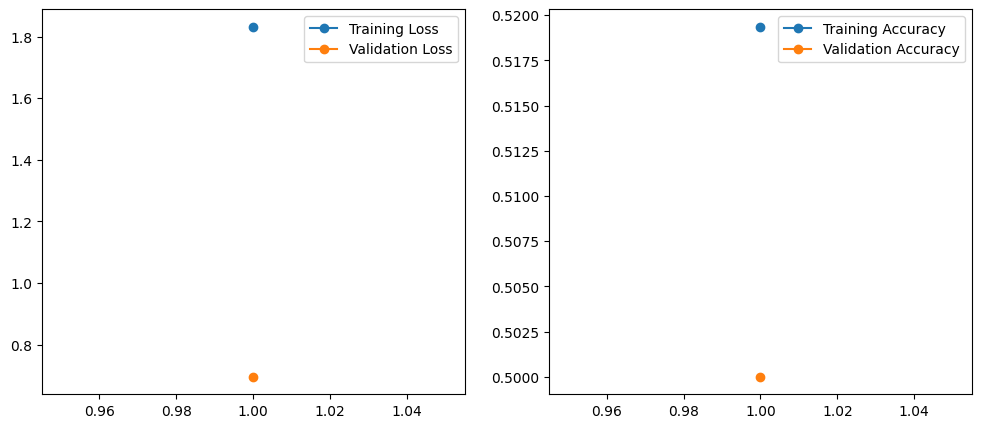

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.4744 - loss: 3.2624 - val_accuracy: 0.5000 - val_loss: 0.6958
Epoch 2/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5441 - loss: 0.7001

2024-12-27 16:39:47.785196: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.5435 - loss: 0.7005 - val_accuracy: 0.5098 - val_loss: 0.6915
Epoch 3/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4895 - loss: 0.7006

2024-12-27 16:39:52.922845: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.4917 - loss: 0.7007 - val_accuracy: 0.5000 - val_loss: 0.6909
Epoch 4/20
 1/20 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.4375 - loss: 0.6925

2024-12-27 16:39:53.967049: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5344 - loss: 0.6943

2024-12-27 16:39:56.074710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5369 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6974
Epoch 5/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5413 - loss: 0.7269

2024-12-27 16:39:58.975466: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.5414 - loss: 0.7272 - val_accuracy: 0.7353 - val_loss: 0.6823
Epoch 6/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5140 - loss: 0.7095

2024-12-27 16:40:01.515821: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5130 - loss: 0.7085 - val_accuracy: 0.5392 - val_loss: 0.6698
Epoch 7/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5174 - loss: 0.7736

2024-12-27 16:40:04.212901: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5185 - loss: 0.7734 - val_accuracy: 0.5784 - val_loss: 0.6641
Epoch 8/20
 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.6094 - loss: 0.6563 

2024-12-27 16:40:04.853215: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.6303 - loss: 0.6832 - val_accuracy: 0.8431 - val_loss: 0.5855
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.5891 - loss: 0.6438 - val_accuracy: 0.5000 - val_loss: 0.9237
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.6468 - loss: 0.6039 - val_accuracy: 0.5294 - val_loss: 1.7228
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.6573 - loss: 0.7308 - val_accuracy: 0.7353 - val_loss: 0.5188
Epoch 12/20
 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7188 - loss: 0.8131 

2024-12-27 16:40:18.245980: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7002 - loss: 0.6752

2024-12-27 16:40:20.232454: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.7027 - loss: 0.6664 - val_accuracy: 0.5588 - val_loss: 0.6447
Epoch 13/20
 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6719 - loss: 0.4975

2024-12-27 16:40:20.798047: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7358 - loss: 0.5029

2024-12-27 16:40:22.817828: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.7395 - loss: 0.4998 - val_accuracy: 0.7647 - val_loss: 0.5735
Epoch 14/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7132 - loss: 0.5985

2024-12-27 16:40:25.375630: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.7153 - loss: 0.5942 - val_accuracy: 0.6078 - val_loss: 0.5527
Epoch 15/20
 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6875 - loss: 0.4920

2024-12-27 16:40:25.825225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.7494 - loss: 0.4424 - val_accuracy: 0.6961 - val_loss: 0.6350
Epoch 16/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8322 - loss: 0.3375

2024-12-27 16:40:32.476154: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.8312 - loss: 0.3430 - val_accuracy: 0.7451 - val_loss: 1.2765
Epoch 17/20
 1/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.7500 - loss: 0.4450

2024-12-27 16:40:33.355707: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8122 - loss: 0.3273

2024-12-27 16:40:35.469389: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.8150 - loss: 0.3264 - val_accuracy: 0.6863 - val_loss: 0.6322
Epoch 18/20


2024-12-27 16:40:38.464380: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8723 - loss: 0.4001

2024-12-27 16:40:40.780471: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8716 - loss: 0.4015 - val_accuracy: 0.6275 - val_loss: 0.9195
Epoch 19/20
 1/20 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - accuracy: 0.8750 - loss: 0.2658

2024-12-27 16:40:41.574012: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8732 - loss: 0.2251

2024-12-27 16:40:43.732276: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.8718 - loss: 0.2274 - val_accuracy: 0.7157 - val_loss: 0.6799
Epoch 20/20
 1/20 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.8125 - loss: 0.2520

2024-12-27 16:40:44.572439: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9078 - loss: 0.1975 - val_accuracy: 0.7647 - val_loss: 1.1762


In [23]:
painters = ["Mondriaan", "Picasso"]
# dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset/undersampled_dataset"
dataset_dir = "undersampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=1)

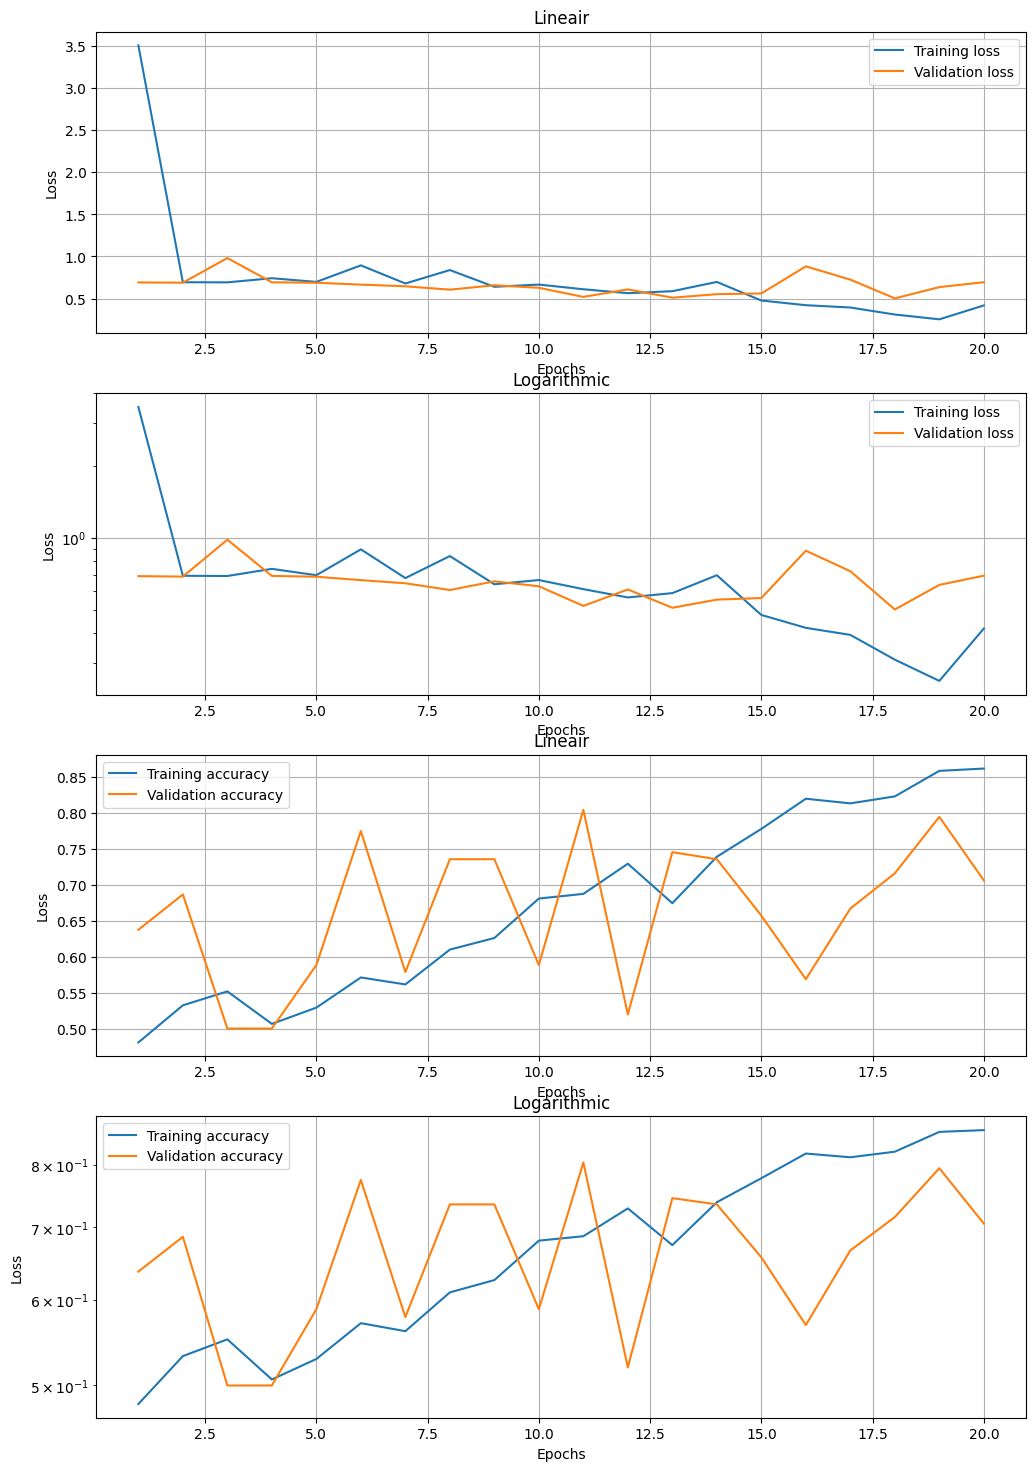

In [14]:
plot_loss(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Accuracy:  0.49019607843137253
Recall:  0.49019607843137253
Precision:  0.49019607843137253
F1:  0.49019607843137253
ROC AUC:  0.4901960784313726


2024-12-27 16:19:31.536070: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


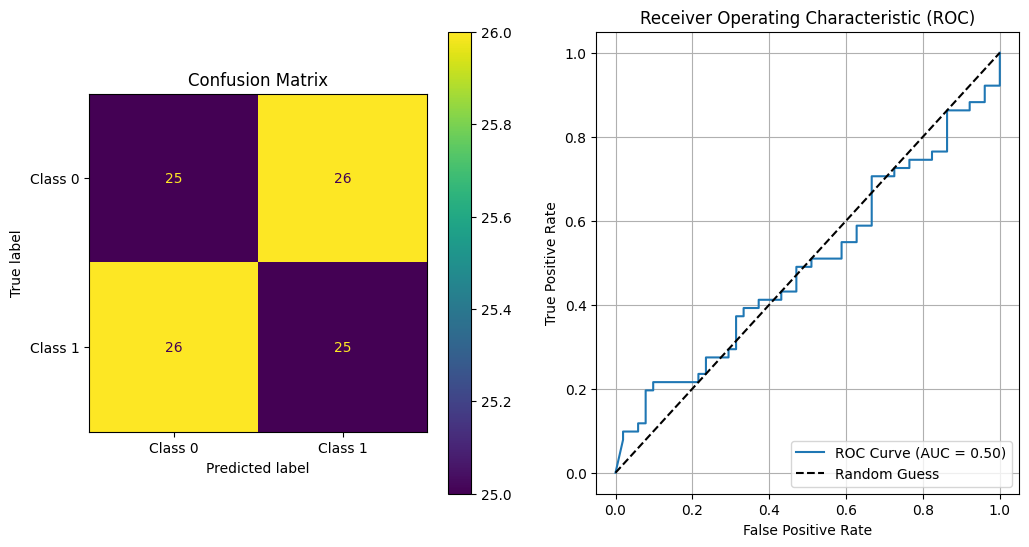

In [15]:
print_metrics(model, test)

## Oversampled dataset

### loading data en model trainen

In [16]:
dataset_dir = "oversampled_dataset"
# dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset/oversampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.5378 - loss: 1.3448 - val_accuracy: 0.6164 - val_loss: 0.6773
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6503 - loss: 0.6614

2024-12-27 16:20:44.833181: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.6506 - loss: 0.6611 - val_accuracy: 0.7656 - val_loss: 0.5060
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7236 - loss: 0.5541

2024-12-27 16:20:58.248757: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.7239 - loss: 0.5535 - val_accuracy: 0.7230 - val_loss: 1.2906
Epoch 4/20
 24/115 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8052 - loss: 0.4961

KeyboardInterrupt: 

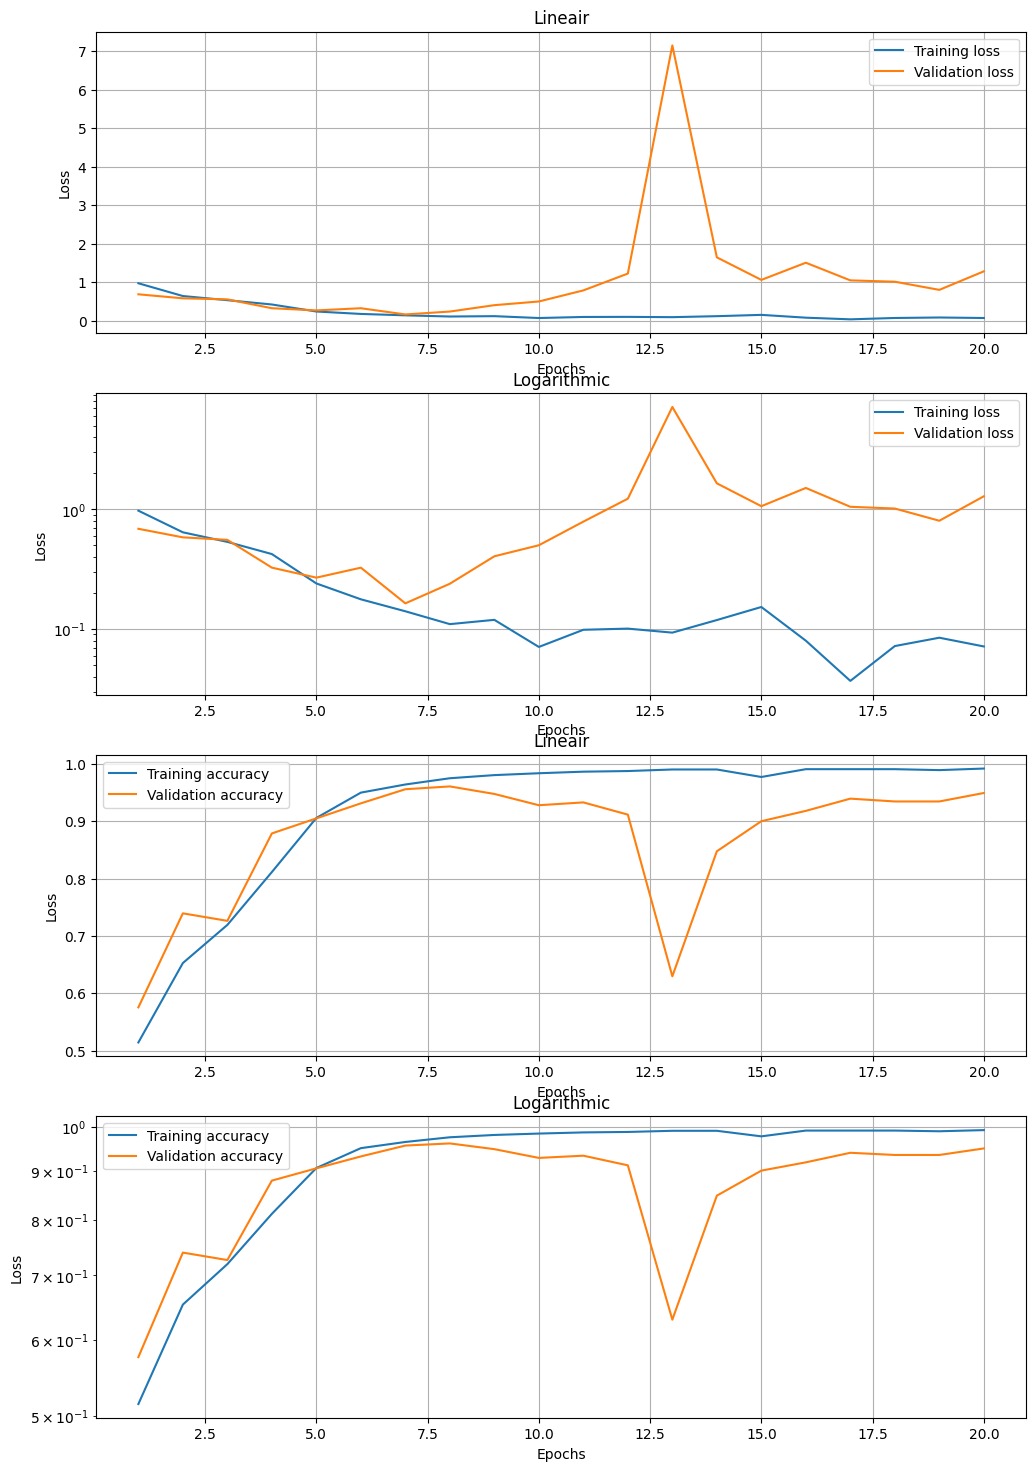

In [13]:
plot_loss(history)

In [14]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
              precision    recall  f1-score   support

           0       0.50      0.53      0.52       305
           1       0.50      0.48      0.49       305

    accuracy                           0.50       610
   macro avg       0.50      0.50      0.50       610
weighted avg       0.50      0.50      0.50       610



## imbalanced dataset

### loading dataset

In [15]:
train, val, test = load_dataset("/kaggle/input/schilderijen-datasets/imbalanced_dataset/imbalanced_dataset", painters, median_width, median_height, batch_size=16)

Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.


### Fitting model 

#### Class weights bepalen

Mondriaan = 0, Picasso = 1

In [16]:
train.class_names

['Mondriaan', 'Picasso']

In [17]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(1115, {0: 198, 1: 917})

Model trainen

In [18]:
mondriaan_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 2.8156565656565657, 1: 0.6079607415485279}

In [19]:
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss")]
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.5548 - loss: 2.4266 - val_accuracy: 0.4070 - val_loss: 0.6947
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.5529 - loss: 0.6976 - val_accuracy: 0.8383 - val_loss: 0.5755
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.5746 - loss: 0.7944 - val_accuracy: 0.5445 - val_loss: 0.6480
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.6357 - loss: 0.7218 - val_accuracy: 0.7305 - val_loss: 0.6069
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.6814 - loss: 0.6314 - val_accuracy: 0.7978 - val_loss: 0.5372
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.6470 - loss: 0.9219 - val_accuracy: 0.5633 - val_loss: 0.6353
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.6858 - loss: 0.5370 - val_accuracy: 0.5256 - val_loss: 0.8034
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.7300 - loss: 0.5038 - val_accuracy: 0

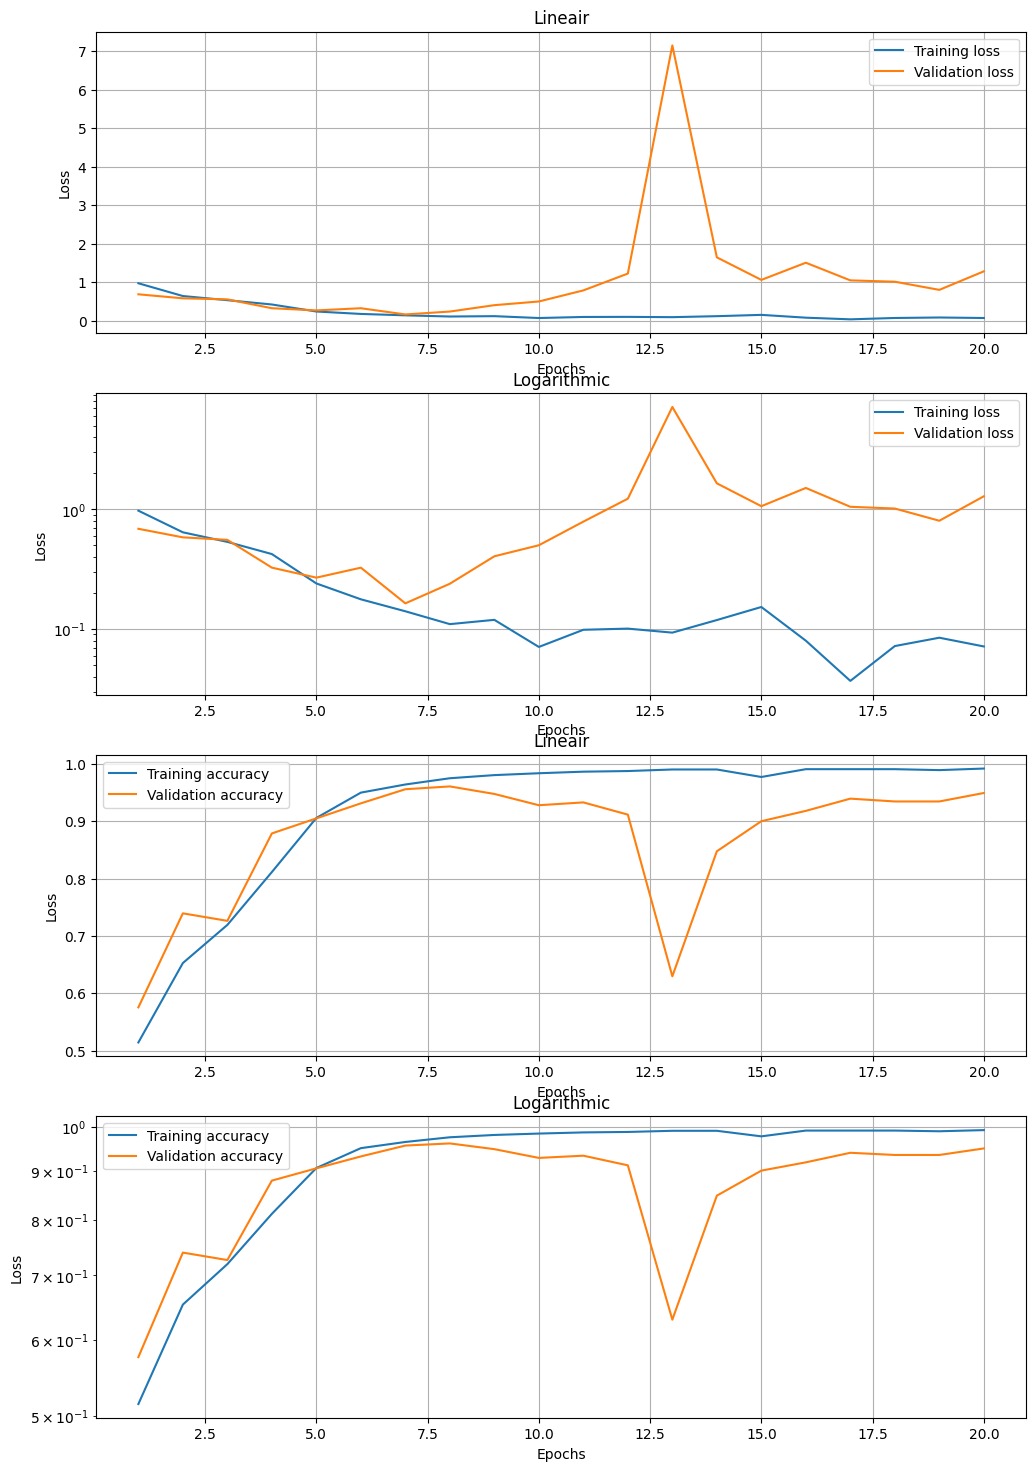

In [20]:
plot_loss(history)

In [21]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
              precision    recall  f1-score   support

           0       0.16      0.14      0.15        66
           1       0.82      0.84      0.83       305

    accuracy                           0.72       371
   macro avg       0.49      0.49      0.49       371
weighted avg       0.70      0.72      0.71       371



Image size bepalen

In [23]:
statistics = ["min", "25%", "median", "mean", "75%"]
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset/imbalanced_dataset"
painters = ["Mondriaan", "Picasso"]

results = []

for statistic in statistics:
    width = int(stats.loc[f"{statistic}", "widths"])
    height = int(stats.loc[f"{statistic}", "heights"])
    for interpolation in interpolations:
        print(statistic, interpolation)
        train, val, test = load_dataset(dataset_dir, painters, width, height, batch_size=16, interpolation=interpolation)
        model = build_model(width, height)
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
        callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss")]
        history = model.fit(train, epochs=15, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

        y_pred = model.predict(test)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        test_accuracy = np.mean(y_pred.flatten() == y_true.flatten())
        
        results.append({
            "statistic": statistic,
            "interpolation": interpolation,
            "width": width,
            "height": height,
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1_score": report["weighted avg"]["f1-score"],
            "support": report["weighted avg"]["support"]
        })
        print(results[-1])

df = pd.DataFrame(results)

min bilinear
Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
{'statistic': 'min', 'interpolation': 'bilinear', 'width': 106, 'height': 115, 'train_accuracy': 0.9730941653251648, 'val_accuracy': 0.9460916519165039, 'test_accuracy': 0.7169811320754716, 'train_loss': 0.08880971372127533, 'val_loss': 0.2392391562461853, 'precision': 0.6930698943870891, 'recall': 0.7169811320754716, 'f1_score': 0.7044749636127506, 'support': 371}
min nearest
Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
{'statistic': 'min', 'interpolation': 'nearest', 'width': 106, 'height': 115, 'train_accuracy': 0.9739910364151001, 'val_accuracy': 0.9353099465370178, 'test_accuracy': 0.7250673854447439, 'train_loss': 0.0630464255809784, 'val_loss': 0.2041139155626297, 'precision': 0.718395670673353

In [26]:
df.sort_values("test_accuracy", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
22,mean,nearest,603,647,0.984753,0.865229,0.789757,0.049925,3.372387,0.705031,0.789757,0.737357,371
32,75%,lanczos3,800,826,0.972197,0.948787,0.765499,0.058881,0.767852,0.708512,0.765499,0.732433,371
15,median,nearest,546,589,0.946188,0.943396,0.752022,0.294562,0.381559,0.719121,0.752022,0.733817,371
17,median,area,546,589,0.970404,0.929919,0.749326,0.144421,1.099276,0.705493,0.749326,0.724976,371
30,75%,bicubic,800,826,0.954260,0.948787,0.746631,0.201048,0.450455,0.699765,0.746631,0.720736,371


In [28]:
df.sort_values("f1_score", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
19,median,lanczos5,546,589,0.956054,0.900270,0.743935,0.325256,0.728317,0.739318,0.743935,0.741584,371
22,mean,nearest,603,647,0.984753,0.865229,0.789757,0.049925,3.372387,0.705031,0.789757,0.737357,371
15,median,nearest,546,589,0.946188,0.943396,0.752022,0.294562,0.381559,0.719121,0.752022,0.733817,371
32,75%,lanczos3,800,826,0.972197,0.948787,0.765499,0.058881,0.767852,0.708512,0.765499,0.732433,371
34,75%,gaussian,800,826,0.961435,0.835580,0.714286,0.135784,0.589976,0.754514,0.714286,0.731434,371


In [29]:
df.sort_values("precisiondf.sort_values("f1_score", ascending=False).head(5)", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
34,75%,gaussian,800,826,0.961435,0.835580,0.714286,0.135784,0.589976,0.754514,0.714286,0.731434,371
19,median,lanczos5,546,589,0.956054,0.900270,0.743935,0.325256,0.728317,0.739318,0.743935,0.741584,371
13,25%,gaussian,313,383,0.952466,0.919137,0.719677,0.167471,0.474499,0.729380,0.719677,0.724378,371
23,mean,bicubic,603,647,0.944395,0.886792,0.706199,0.278986,0.705670,0.727496,0.706199,0.716171,371
33,75%,lanczos5,800,826,0.965919,0.897574,0.714286,0.185230,0.421453,0.727338,0.714286,0.720551,371


In [30]:
df.sort_values("recall", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
22,mean,nearest,603,647,0.984753,0.865229,0.789757,0.049925,3.372387,0.705031,0.789757,0.737357,371
32,75%,lanczos3,800,826,0.972197,0.948787,0.765499,0.058881,0.767852,0.708512,0.765499,0.732433,371
15,median,nearest,546,589,0.946188,0.943396,0.752022,0.294562,0.381559,0.719121,0.752022,0.733817,371
17,median,area,546,589,0.970404,0.929919,0.749326,0.144421,1.099276,0.705493,0.749326,0.724976,371
30,75%,bicubic,800,826,0.954260,0.948787,0.746631,0.201048,0.450455,0.699765,0.746631,0.720736,371


In [27]:
df.sort_values("val_loss").head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
9,25%,bicubic,313,383,0.950673,0.946092,0.725067,0.169997,0.192346,0.687137,0.725067,0.704884,371
2,min,bicubic,106,115,0.959641,0.948787,0.706199,0.099885,0.194311,0.704445,0.706199,0.705319,371
1,min,nearest,106,115,0.973991,0.935310,0.725067,0.063046,0.204114,0.718396,0.725067,0.721667,371
0,min,bilinear,106,115,0.973094,0.946092,0.716981,0.088810,0.239239,0.693070,0.716981,0.704475,371
6,min,gaussian,106,115,0.979372,0.962264,0.743935,0.052606,0.243345,0.719174,0.743935,0.730594,371


In [31]:
df.to_csv("image_size_gridsearch_result.csv")